
每列的缺失统计:
            Not Missing Count  Missing Count  Missing Rate
label                     709              0           0.0
Gender                    709              0           0.0
Age                       709              0           0.0
BMI                       709              0           0.0
SBP                       709              0           0.0
...                       ...            ...           ...
Busyness                  709              0           0.0
Coarseness                709              0           0.0
Complexity                709              0           0.0
Contrast.1                709              0           0.0
Strength                  709              0           0.0

[131 rows x 3 columns]

阴性数据形状: (363, 131)
阳性数据形状: (346, 131)

类别分布:
0    363
1    346
Name: label, dtype: int64


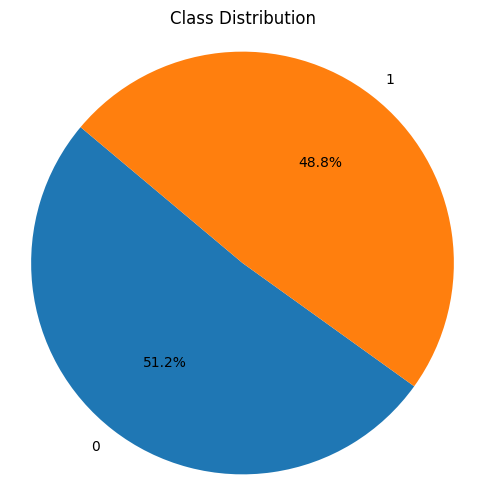


独立样本t检验结果:

显著特征数量: 80

Lasso选择的特征数量: 17

Lasso选择的特征及系数值:
                   特征名       系数值
                   BMI  0.147973
                   SBP  0.100413
                   GGT  0.019817
                    TG  0.047767
                    TC  0.034991
                HbA 1c  0.057899
               Minimum -0.045531
              VoxelNum -0.016497
Maximum2DDiameterSlice  0.036075
          10Percentile  0.003631
              Kurtosis -0.008615
              Skewness  0.000677
           Correlation  0.021991
                  Imc1 -0.018922
GrayLevelNonUniformity -0.012160
     SmallAreaEmphasis -0.022008
           ZoneEntropy  0.033511


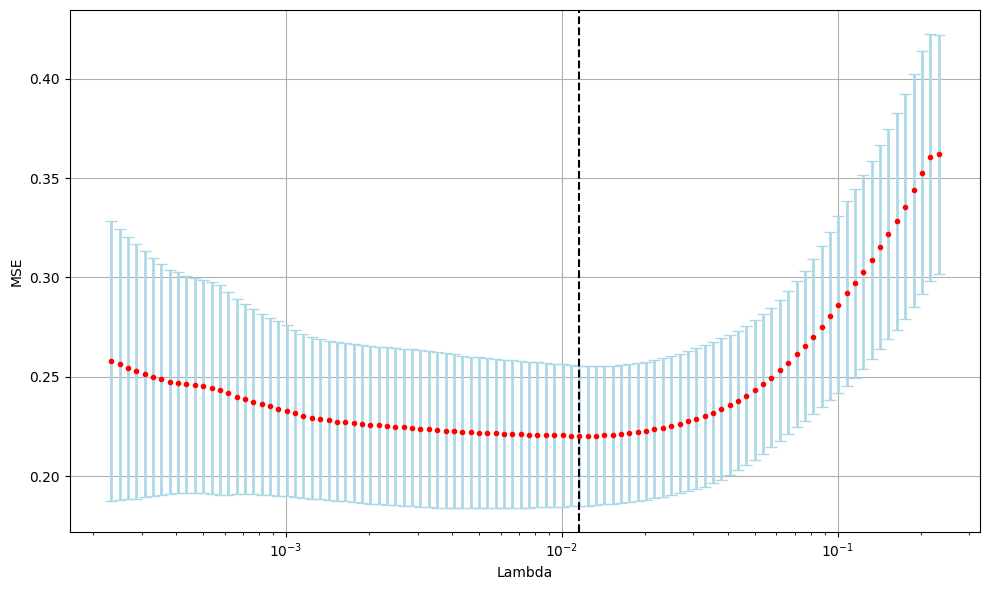

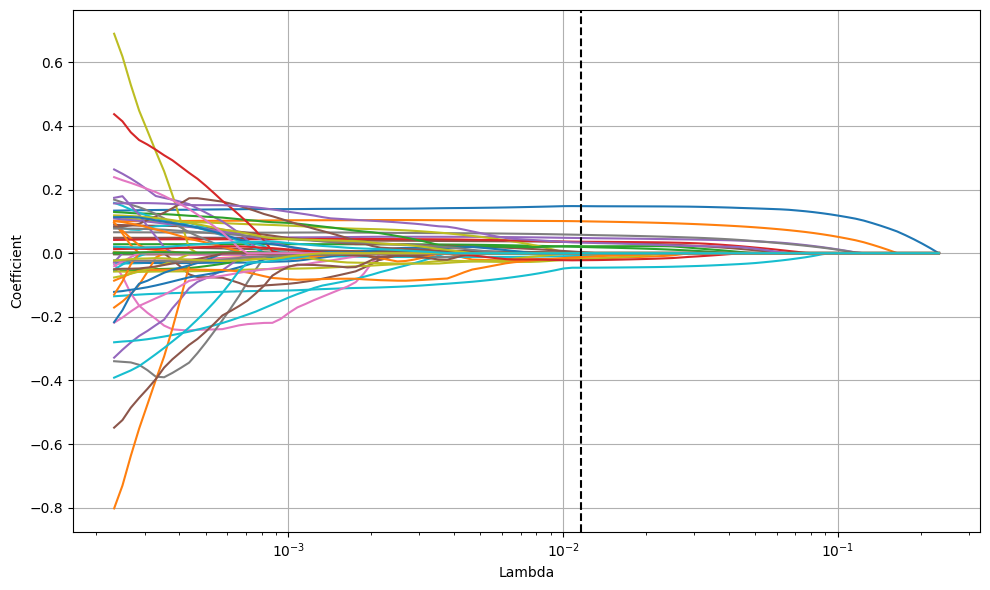

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# 读取阳性和阴性文件
data_oa = pd.read_csv('RESULT.oa.csv')
data_non = pd.read_csv('RESULT.non oa.csv')

# 合并数据
data = pd.concat([data_oa, data_non])

# 统计每列的缺失总数
missing_count = data.isnull().sum()

# 计算每列的未缺失总数
not_missing_count = data.notnull().sum()

# 计算每列的缺失率
missing_rate = missing_count / len(data)

# 获取原始阴阳数据的形状
data_shape_oa = data_oa.shape
data_shape_non = data_non.shape

# 打印每列的缺失总数、未缺失总数、缺失率和原始数据的形状
print("\n每列的缺失统计:")
missing_stats = pd.DataFrame({
    'Missing Count': missing_count,
    'Not Missing Count': not_missing_count,
    'Missing Rate': missing_rate
})
# 重新排列列的顺序
missing_stats = missing_stats[['Not Missing Count', 'Missing Count', 'Missing Rate']]
print(missing_stats)

# 打印阴阳数据的形状
print(f"\n阴性数据形状: {data_shape_non}")
print(f"阳性数据形状: {data_shape_oa}")

# 填充缺失值，这里假设缺失值用0填充
data.fillna(0, inplace=True)

# 分离特征和标签
X = data.drop(columns=['label'])
y = data['label']

# 统计类别占比
class_counts = y.value_counts()
print("\n类别分布:")
print(class_counts)

# 绘制类别占比饼图
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# 独立样本t检验
group1 = X[y == 0]  # 阴性样本
group2 = X[y == 1]  # 阳性样本

significant_features = []
alpha = 0.05

print("\n独立样本t检验结果:")
for column in X.columns:
    t_stat, p_value = ttest_ind(group1[column], group2[column])
    # print(f'T检验 - {column}: t_stat = {t_stat:.4f}, p_value = {p_value:.4f}')
    if p_value < alpha:
        significant_features.append(column)

# 筛选显著特征
X_significant = X[significant_features]
print(f"\n显著特征数量: {len(significant_features)}")

# 数据标准化
scaler = StandardScaler()
X_significant_scaled = scaler.fit_transform(X_significant)

# 进行Lasso回归以选择特征
lasso = LassoCV(cv=5, max_iter=100000)
lasso.fit(X_significant_scaled, y)

# 输出非零系数对应的特征及系数值
lasso_coef = pd.Series(lasso.coef_, index=significant_features)
selected_features = lasso_coef[lasso_coef != 0].index
lasso_coef_values = lasso_coef[lasso_coef != 0].values
print(f"\nLasso选择的特征数量: {len(selected_features)}")
print("\nLasso选择的特征及系数值:")
lasso_coef_table = pd.DataFrame({
    '特征名': selected_features,
    '系数值': lasso_coef_values
})
print(lasso_coef_table.to_string(index=False))
# 绘制 Lasso 交叉验证 MSE 路径图
alphas = lasso.alphas_
MSEs_mean = np.mean(lasso.mse_path_, axis=1)
MSEs_std = np.std(lasso.mse_path_, axis=1)

plt.figure(figsize=(10, 6))
plt.errorbar(alphas, MSEs_mean, yerr=MSEs_std, fmt='o', ms=3, mfc='r', mec='r', ecolor='lightblue', elinewidth=2, capsize=4, capthick=1)
plt.semilogx()
plt.axvline(lasso.alpha_, color='black', ls='--')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.grid(True)
plt.tight_layout()
plt.show()

# 计算并绘制 Lasso 系数路径图
alphas_, coefs_path, _ = lasso.path(X_significant_scaled, y, alphas=alphas, max_iter=100000)
coefs = coefs_path.T

plt.figure(figsize=(10, 6))
plt.semilogx(alphas_, coefs, '-')
plt.axvline(lasso.alpha_, color='black', ls='--')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

# 选择Lasso选择的特征进行逻辑回归
X_selected = X[selected_features]

# 划分训练集和测试集，并混洗数据
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, shuffle=True)

# 对训练集和测试集进行数据标准化
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# 设置图形的常量值
lw = 2
color = "darkorange"
figsize = (8,6)
line_color = "gray"

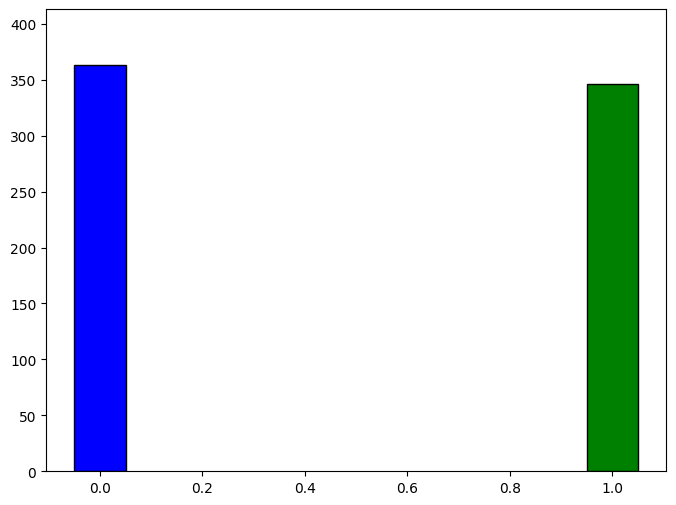

In [2]:
# 查看训练数据样本是否平衡
# 将训练集的标签转换为numpy数组并重新整形
train_labels = np.array(y_train.astype(np.int64)).reshape((-1,))
# 设置柱状图的颜色列表
colors = ['blue', 'green']
# 绘制训练集标签的柱状图
plt.figure(figsize=figsize)
plt.bar(np.unique(train_labels), class_counts, width=0.1, align='center', edgecolor='black', color=colors)
# plt.xlabel('Class Label')
# plt.ylabel('Count')
# plt.title('Class Distribution of Training Data')
plt.xticks(np.arange(0.0, 1.2, step=0.2))  # 设置x轴刻度范围和步长
plt.ylim(0, max(class_counts) + 50)  # 设置y轴的上限，以便显示所有的柱子
plt.subplots_adjust(wspace=0.5)  # 调整子图之间的间距
plt.show()


逻辑回归模型准确率: 0.7606

混淆矩阵:
[[77 20]
 [31 85]]

分类报告:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75        97
           1       0.81      0.73      0.77       116

    accuracy                           0.76       213
   macro avg       0.76      0.76      0.76       213
weighted avg       0.77      0.76      0.76       213


ROC AUC: 0.8468


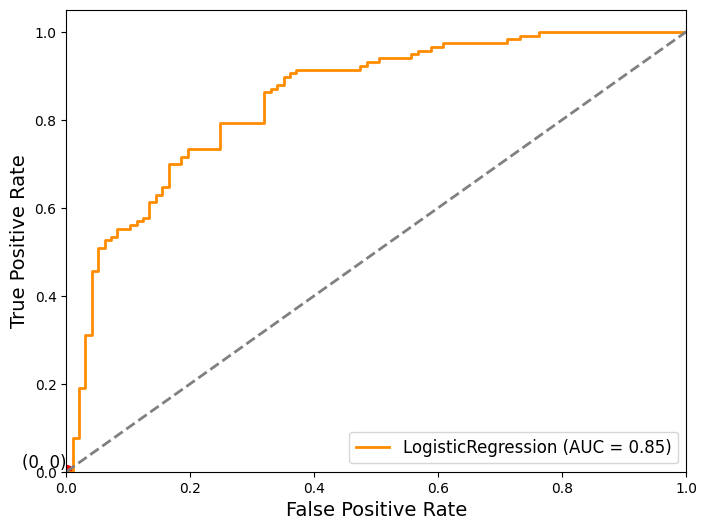

In [3]:
# 训练二分类逻辑回归模型
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
log_reg = LogisticRegression(solver='liblinear', max_iter=20000)
log_reg.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\n逻辑回归模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label=f'LogisticRegression (AUC = {roc_auc:.2f})')
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()



SVC模型准确率: 0.7606

混淆矩阵:
[[76 21]
 [30 86]]

分类报告:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        97
           1       0.80      0.74      0.77       116

    accuracy                           0.76       213
   macro avg       0.76      0.76      0.76       213
weighted avg       0.76      0.76      0.76       213


ROC AUC: 0.8475


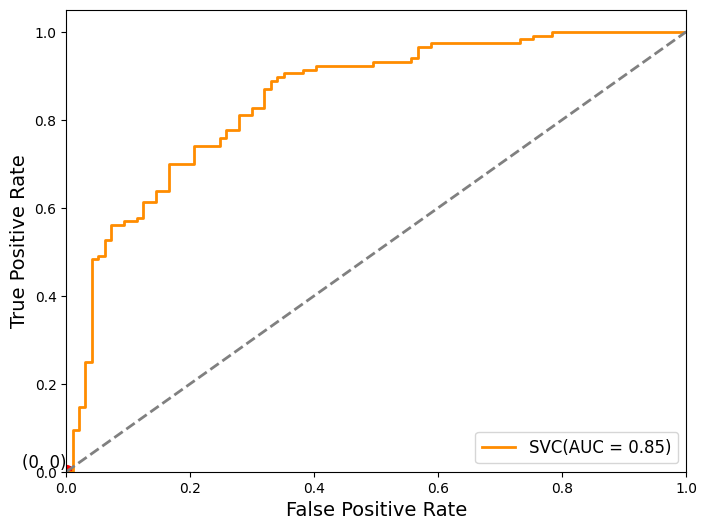

In [4]:
# 创建SVC训练模型
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report

# 初始化SVC模型
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = svc.predict(X_test_scaled)
y_prob = svc.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\nSVC模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label=f'SVC(AUC = {roc_auc:.2f})')
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


随机森林模型准确率: 0.8169

混淆矩阵:
[[83 14]
 [25 91]]

分类报告:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        97
           1       0.87      0.78      0.82       116

    accuracy                           0.82       213
   macro avg       0.82      0.82      0.82       213
weighted avg       0.82      0.82      0.82       213


ROC AUC: 0.9013


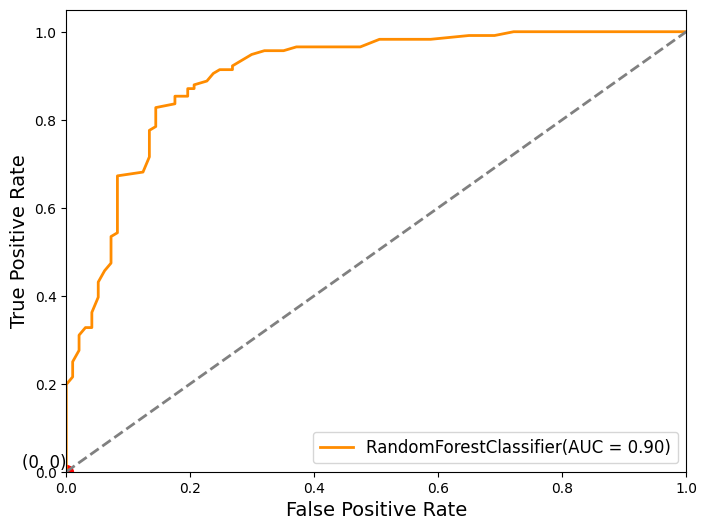

In [5]:
# 创建随机森林模型
from sklearn.ensemble import RandomForestClassifier
# 初始化随机森林模型
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = rf_classifier.predict(X_test_scaled)
y_prob = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\n随机森林模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label=f'RandomForestClassifier(AUC = {roc_auc:.2f})')
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
# plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


LightGBM模型准确率: 0.8498

混淆矩阵:
[[84 13]
 [19 97]]

分类报告:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        97
           1       0.88      0.84      0.86       116

    accuracy                           0.85       213
   macro avg       0.85      0.85      0.85       213
weighted avg       0.85      0.85      0.85       213


ROC AUC: 0.9110


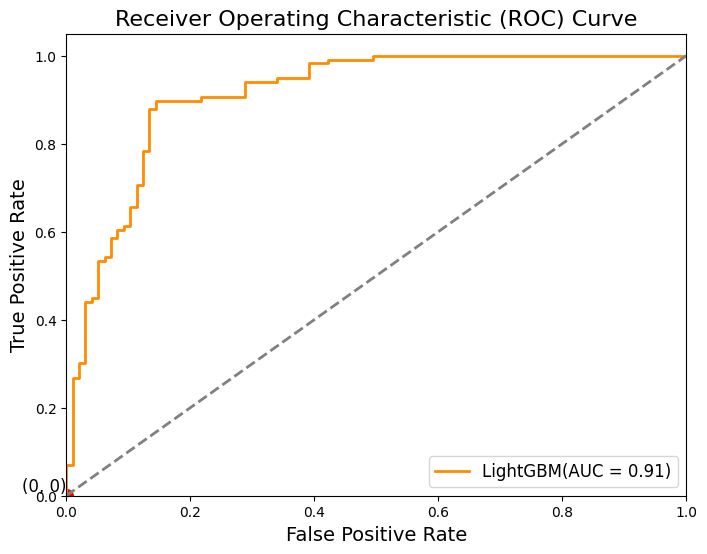

In [6]:
# 创建LightGBM模型
import lightgbm as lgb
import logging
# 设置日志级别为 ERROR
logging.basicConfig(level=logging.ERROR)
# 初始化LightGBM模型
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100, verbosity=-1)
lgb_classifier.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = lgb_classifier.predict(X_test_scaled)
y_prob = lgb_classifier.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLightGBM模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label=f'LightGBM(AUC = {roc_auc:.2f})')
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


XGBoost模型准确率: 0.8075

混淆矩阵:
[[80 17]
 [24 92]]

分类报告:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        97
           1       0.84      0.79      0.82       116

    accuracy                           0.81       213
   macro avg       0.81      0.81      0.81       213
weighted avg       0.81      0.81      0.81       213


ROC AUC: 0.8971


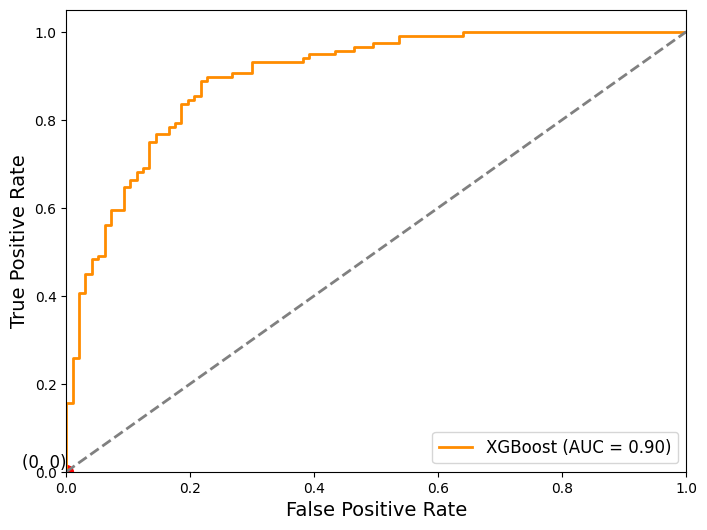

In [7]:
# 创建XGB（eXtreme Gradient Boosting梯度提升XGB）模型
from xgboost import XGBClassifier
# 初始化XGBoost模型
xgb_classifier = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = xgb_classifier.predict(X_test_scaled)
y_prob = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\nXGBoost模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()


高斯朴素贝叶斯模型准确率: 0.7324

混淆矩阵:
[[64 33]
 [24 92]]

分类报告:
              precision    recall  f1-score   support

           0       0.73      0.66      0.69        97
           1       0.74      0.79      0.76       116

    accuracy                           0.73       213
   macro avg       0.73      0.73      0.73       213
weighted avg       0.73      0.73      0.73       213


ROC AUC: 0.8031


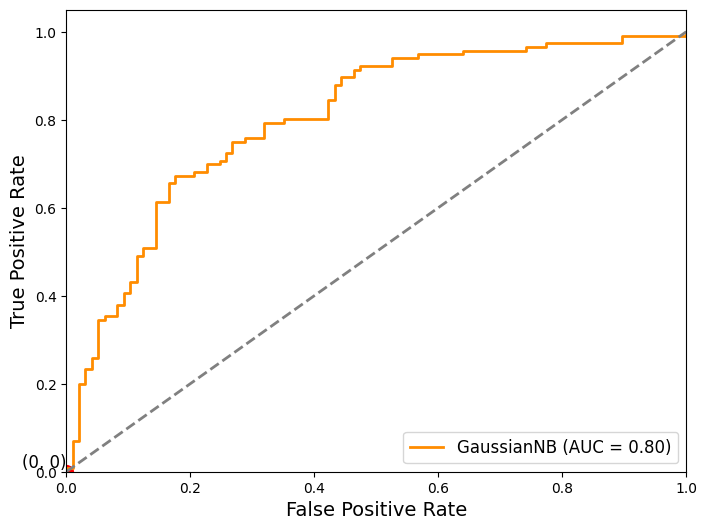

In [8]:
# 创建GNB(高斯朴素贝叶斯，Gaussian Naive Bayes)模型
# 创建高斯朴素贝叶斯模型
from sklearn.naive_bayes import GaussianNB

# 初始化高斯朴素贝叶斯模型
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = gnb_classifier.predict(X_test_scaled)
y_prob = gnb_classifier.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\n高斯朴素贝叶斯模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label='GaussianNB (AUC = %0.2f)' % roc_auc)
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()


梯度提升机模型准确率: 0.8263

混淆矩阵:
[[84 13]
 [24 92]]

分类报告:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        97
           1       0.88      0.79      0.83       116

    accuracy                           0.83       213
   macro avg       0.83      0.83      0.83       213
weighted avg       0.83      0.83      0.83       213


ROC AUC: 0.9072


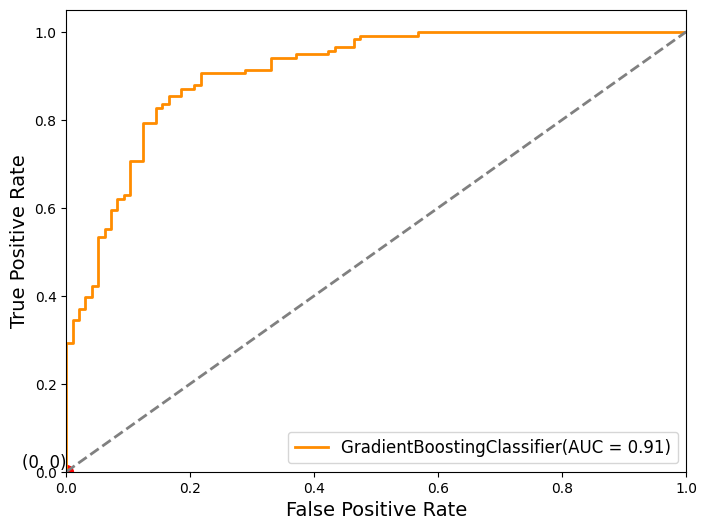

In [9]:
# 创建GBM模型
# 创建梯度提升机模型
from sklearn.ensemble import GradientBoostingClassifier

# 初始化梯度提升机模型
gbm_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gbm_classifier.fit(X_train_scaled, y_train)

# 预测测试集
y_pred = gbm_classifier.predict(X_test_scaled)
y_prob = gbm_classifier.predict_proba(X_test_scaled)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"\n梯度提升机模型准确率: {accuracy:.4f}")

# 输出混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n混淆矩阵:")
print(conf_matrix)

# 输出分类报告
class_report = classification_report(y_test, y_pred)
print("\n分类报告:")
print(class_report)

# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC: {roc_auc:.4f}")

# 绘制ROC曲线
plt.figure(figsize=figsize)
plt.plot(fpr, tpr, color=color, lw=lw, label='GradientBoostingClassifier(AUC = %0.2f)' % roc_auc)
plt.scatter([0], [0], color='red', s=100)
plt.text(0, 0, '(0, 0)', fontsize=12, verticalalignment='bottom', horizontalalignment='right')
plt.plot([0, 1], [0, 1], color=line_color, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.show()
